In [73]:
import os
import sys
import h5py


from models.models import Attention, GatedAttention, AdditiveAttention, ModAdditiveAttention
from wsi_datasets import tumor_collate, tumor_pad_collate_fn, gene_pad_collate_fn, gene_collate, TumorEmbeddingDataset, GeneExpressionDataset

# ==================================================================================
 
import numpy as np
import math
import matplotlib.pyplot as plt

# ============================== Torch Imports =====================================

import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn

import pickle

In [70]:
# Single WSI HDF5 file 
SLIDE_HDF5 = "/media/mdastorage/cf1ee3be-f161-4614-b2dd-030a9adfc5fc_20x.hdf5"

# Model weights files
MODEL_WEIGHTS_FILE_TUMOR = "../model_weights/tumor_detection/LUSC_TUMOR_5x/baselines/attention_62_25.pt"
MODEL_WEIGHTS_FILE_TP53 = "../model_weights/gene_expression/BRCA_TP53_20x/baselines/additive_68_15.pt"

# WSI dataset HDF5 file
DATASET_HDF5 = "../datasets/tumor_detection/LUSC_TUMOR_5x.hdf5"

# CSV file with WSI metadata
SLIDE_DATA_FILE = "../slide_data/LUSC_TUMOR.csv"


CUDA_DEVICE = "cuda:0"

torch.cuda.init()
torch.cuda.memory_summary(device=None, abbreviated=False)

cuda = torch.cuda.is_available()
device = torch.device(CUDA_DEVICE)
collate = tumor_pad_collate_fn

In [63]:
dataset = TumorEmbeddingDataset(DATASET_HDF5)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

torch.manual_seed(11)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [64]:
model = Attention().to(device)
model.load_state_dict(torch.load(MODEL_WEIGHTS_FILE_TUMOR))

<All keys matched successfully>

In [65]:

def remove_padding(data):
    mask = np.all(np.array(data) != -np.Inf, axis=1)
    return data[mask]
# ========================================== Validation Functions =====================================================

# get_scores: returns the attention patch scores and additive patch scores for an embedding, 
# along with the corresponding patch coordinates
def get_scores(model, embedding, coords, label):
    model.eval()
    if cuda:
        embedding, label = embedding.to(device), label.to(device)
    loss, a_scores, ad_scores = model.calculate_objective(embedding, label)
    error, Y_hat, Y_prob = model.calculate_classification_error(embedding, label) 
    return coords, a_scores, ad_scores, Y_hat

# get_scores_for_all_embeddings: takes a dataset of WSI patch embeddings and returns the
# attention and additive scores, along with the corresponding patch coordinates
def get_scores_for_all_embeddings(model, dataset):
    scores = {}
    dataloader = data_utils.DataLoader(dataset, batch_size=1, num_workers=0, shuffle=True, pin_memory=True, collate_fn=collate)
    for batch_idx, (data, coords, labels, path, _, aug_flags) in enumerate(dataloader):
        for data_element, label, is_aug in zip(data, labels, aug_flags):
            if is_aug:
                break
            if cuda:
                data_element, label = data_element.to(device), label.to(device)

            loss, a_scores, ad_scores = model.calculate_objective(data_element, label)
            error, Y_hat, Y_prob = model.calculate_classification_error(data_element, label) 
            
            slide_id = path[0]
            scores[slide_id] = {
                "label": label, 
                "pred": Y_hat,
                "coords": coords[0], 
                "attention_scores": a_scores,
                "additive_scores": ad_scores
                }

    return scores

# get_single_embedding_scores: returns the attention and additive patch scores for a WSI embeddings in a single file
def get_single_embedding_scores(model, file, slide_id):
    scores = {}
    with h5py.File(file, "r") as f:
        slide_info = f["slide"]
        embeddings = torch.tensor(np.array(slide_info["embeddings"]))
        coords = torch.tensor(np.array(slide_info["coords"]))
        print(coords.shape)
        label = torch.tensor(np.array(1))
        coords, a_scores, ad_scores, Y_hat = get_scores(model, embeddings, coords, label)
        scores[slide_id] = {
            "label": label, 
            "pred": Y_hat,
            "coords": coords, 
            "attention_scores": a_scores,
            "additive_scores": ad_scores
        }
        return scores

In [66]:
from utils.gdc_api_utils import getTile
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib as mpl

cmap = cm.get_cmap('coolwarm', lut=512) 


def get_pixels_per_patch(magnification_level):
    levels = magnification_level - 9 
    num_tiles = 2**levels
    pixels_per_patch = int(512/num_tiles)
    return pixels_per_patch

def get_pixel_color(attention, score):
    if attention:
        color = np.array(cmap(score))
    else:
        if score >= 0.5:
            color = np.array([0.8,0.2,0.2])
        else:
            color = np.array([0.2,0.2,0.8])
    return color

# getPixelsInThumbnail: given the slide id, its magnification level, the coords and the corresponding scores,
# it fetches the WSI at thumbanil level from the GDC API and paints it according with the scores
# If the scores are from the attention layer (attention=True) it paints according with a colormap 
# If the scores are the additive scores (attention=False), it paints according with if they are positive (red) 
# or negative (blue)
def getPixelsInThumbnail(slide_id, magnification_level, coords, scores, show_original=False, attention=True):
    img = getTile(slide_id, 9, 0, 0)
    img = np.array(img).transpose((1,0,2))

    if show_original:
        original_img = img.transpose((1,0,2)).copy()

    pixels_per_patch = get_pixels_per_patch(magnification_level)
    scores = scores.cpu().detach().numpy()
    print(coords)
    for index in range(len(coords)):
        pixel_x = int(coords[index][0] * pixels_per_patch)
        pixel_y = int(coords[index][1] * pixels_per_patch)
        pixels_to_color = img[pixel_x:pixel_x+pixels_per_patch, pixel_y:pixel_y+pixels_per_patch, :]
        score = scores[0][index]
        score = (score - scores.min()) / (scores.max() - scores.min())

        color = get_pixel_color(attention, score)

        np.multiply(pixels_to_color, color[:3] , out=pixels_to_color, casting="unsafe")

    
    img = img.transpose((1,0,2))

    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img)
    if show_original:
        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(original_img)
    plt.axis('off')
    plt.show()

/tmp/ipykernel_3894150/795811878.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm', lut=512)


In [67]:
import pandas as pd
from math import log2

def get_slide_level(slide_id, magnification, csv_filename):
    '''
    Given a set of slide ids and the pretended magnification, it returns the correct magnification levels, according to the csv file
    '''
    slide_info = pd.read_csv(csv_filename)
    slide_info = slide_info.loc[slide_info['slide_id'] == slide_id].to_dict(orient='records')[0]

    if round(slide_info["mpp"],1) not in [0.2,0.3,0.5]:
        return -1
    max_magnification = 10/slide_info["mpp"]
    levels_to_decrease = int(log2( max_magnification / magnification))
    return slide_info["max_level"] - levels_to_decrease



def visualize_scores(scores, magnification_level, slide_data, score_type="attention", show_original=True):
    for slide_id, values in scores.items():
        pred = scores[slide_id]["pred"]
        label = scores[slide_id]["label"]
        print("Label: ", label, "Prediction: ", pred)
        slide_level = get_slide_level(slide_id, magnification_level, slide_data)
        attention = True if score_type == "attention" else False
        score = scores[slide_id]["attention_scores"] if score_type == "attention" else scores[slide_id]["additive_scores"]
        getPixelsInThumbnail(slide_id, slide_level, scores[slide_id]["coords"], score, show_original, attention)

Label:  tensor([1], device='cuda:0') Prediction:  tensor([[1.]], device='cuda:0')
tensor([[3, 2],
        [4, 3],
        [3, 4],
        [4, 2],
        [4, 5],
        [5, 0],
        [5, 4],
        [3, 3],
        [4, 0],
        [1, 2],
        [6, 3],
        [4, 1],
        [6, 1],
        [6, 4],
        [5, 1],
        [2, 4],
        [0, 2],
        [3, 1],
        [2, 3],
        [1, 4],
        [7, 3],
        [5, 2],
        [4, 4],
        [2, 1],
        [2, 2],
        [1, 3],
        [5, 3],
        [6, 2],
        [0, 3],
        [5, 5]])


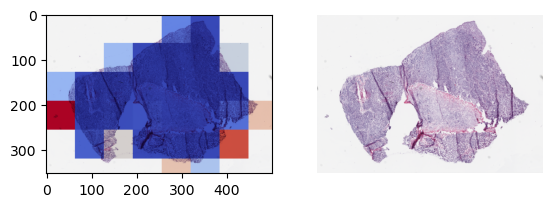

Label:  tensor([0], device='cuda:0') Prediction:  tensor([[0.]], device='cuda:0')
tensor([[3, 2],
        [3, 3],
        [1, 2],
        [3, 0],
        [2, 0],
        [2, 4],
        [1, 1],
        [0, 2],
        [3, 1],
        [2, 3],
        [1, 4],
        [2, 1],
        [1, 0],
        [2, 2],
        [0, 1],
        [1, 3],
        [0, 3],
        [0, 0],
        [1, 5]])


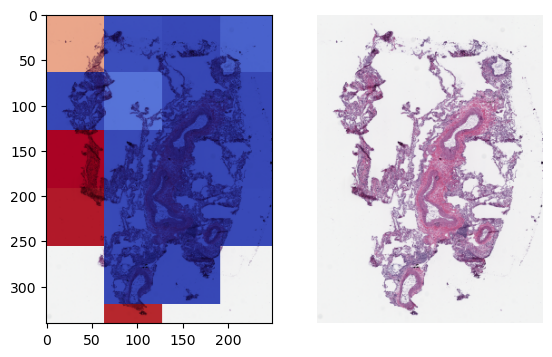

Label:  tensor([1], device='cuda:0') Prediction:  tensor([[1.]], device='cuda:0')
tensor([[ 9,  4],
        [ 3,  2],
        [ 4,  3],
        [ 3,  4],
        [ 4,  2],
        [ 8,  6],
        [10,  2],
        [ 4,  5],
        [ 7,  6],
        [ 8,  2],
        [ 5,  9],
        [ 8,  8],
        [ 9,  5],
        [ 2,  6],
        [ 6,  7],
        [10,  1],
        [ 2,  5],
        [ 5,  4],
        [ 9,  3],
        [ 3,  3],
        [ 1,  8],
        [ 1,  2],
        [ 6,  3],
        [ 4,  7],
        [ 4,  1],
        [ 8,  1],
        [ 6,  1],
        [ 6,  4],
        [ 8,  4],
        [ 5,  1],
        [ 4,  6],
        [ 3,  8],
        [ 6,  6],
        [ 2,  8],
        [ 8,  5],
        [ 7,  5],
        [ 3,  7],
        [ 9,  2],
        [10,  4],
        [11,  1],
        [ 1,  7],
        [ 2,  4],
        [ 8,  3],
        [ 7,  8],
        [ 7,  4],
        [ 7,  2],
        [ 3,  9],
        [ 3,  1],
        [11,  4],
        [ 5,  6],
        [ 8,  7],


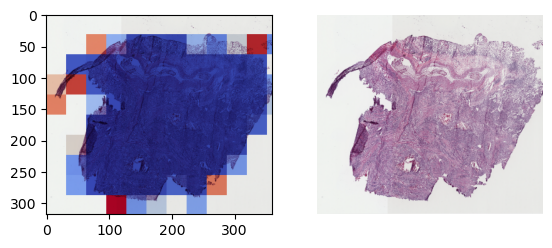

Label:  tensor([1], device='cuda:0') Prediction:  tensor([[1.]], device='cuda:0')
tensor([[ 9,  4],
        [ 3,  2],
        [ 1, 10],
        [ 4,  3],
        [ 3,  4],
        [ 0,  6],
        [ 4,  2],
        [ 8,  6],
        [ 4,  5],
        [ 7,  6],
        [ 6,  0],
        [ 8,  2],
        [ 7,  0],
        [ 5,  9],
        [ 8,  8],
        [ 9,  5],
        [ 2,  6],
        [ 2,  9],
        [ 6,  7],
        [ 0,  8],
        [ 2,  5],
        [ 5,  4],
        [ 9,  3],
        [ 3,  3],
        [ 1,  8],
        [ 6,  3],
        [ 4,  7],
        [ 6,  9],
        [ 4,  1],
        [ 6,  1],
        [ 6,  4],
        [ 8,  4],
        [ 5,  1],
        [ 4,  6],
        [ 3,  8],
        [ 6,  6],
        [ 2,  8],
        [ 8,  5],
        [10,  6],
        [ 7,  5],
        [ 3,  7],
        [ 9,  2],
        [10,  4],
        [ 1,  9],
        [ 1,  7],
        [ 2,  4],
        [ 8,  3],
        [ 7,  8],
        [ 7,  4],
        [ 7,  2],
        [ 4, 10],


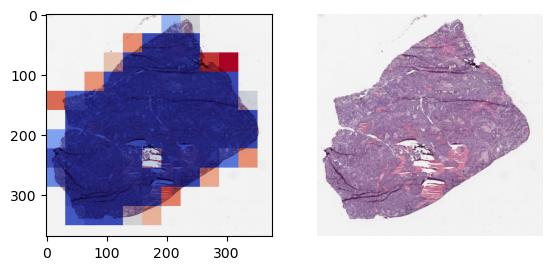

Label:  tensor([1], device='cuda:0') Prediction:  tensor([[1.]], device='cuda:0')
tensor([[3, 2],
        [4, 3],
        [3, 4],
        [4, 2],
        [6, 0],
        [5, 0],
        [5, 4],
        [3, 3],
        [4, 0],
        [1, 2],
        [6, 3],
        [4, 1],
        [6, 1],
        [6, 4],
        [5, 1],
        [2, 4],
        [7, 4],
        [7, 2],
        [0, 2],
        [3, 1],
        [2, 3],
        [1, 4],
        [7, 3],
        [5, 2],
        [7, 1],
        [4, 4],
        [0, 4],
        [2, 1],
        [2, 2],
        [1, 3],
        [5, 3],
        [6, 2],
        [0, 3]])


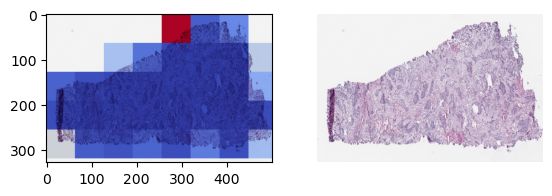

Label:  tensor([1], device='cuda:0') Prediction:  tensor([[1.]], device='cuda:0')


KeyboardInterrupt: 

In [68]:
scores = get_scores_for_all_embeddings(model, test_dataset)
visualize_scores(scores, 5, SLIDE_DATA_FILE, show_original=True)

torch.Size([1176, 2])
Label:  tensor(1) Prediction:  tensor(1, device='cuda:0')
tensor([[19., 51.],
        [23., 18.],
        [12., 42.],
        ...,
        [24., 34.],
        [ 9., 40.],
        [34., 28.]])


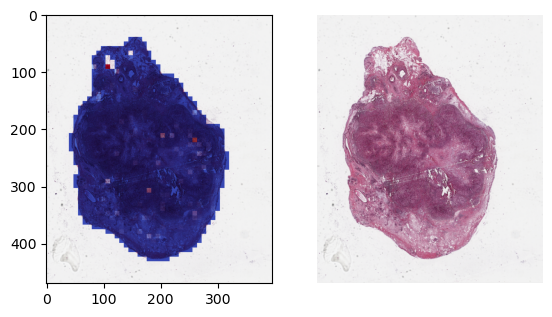

In [71]:
model = AdditiveAttention().to(device)
model.load_state_dict(torch.load(MODEL_WEIGHTS_FILE_TP53))

scores = get_single_embedding_scores(model, SLIDE_HDF5, "cf1ee3be-f161-4614-b2dd-030a9adfc5fc")
slide_file = "../slide_data/BRCA_TP53.csv"
visualize_scores(scores, 20, slide_file, show_original=True)